<a href="https://colab.research.google.com/github/bhattadeb34/FACT_Data_Extraction_Scientific_Papers/blob/main/LLm_embeddings_analysis_Oct25_2025_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas sentence-transformers scikit-learn matplotlib seaborn umap-learn

In [2]:
!pip install openai

In [40]:
# Cell 1: Imports and Configuration (Modified)

import os
import re
import pandas as pd
import numpy as np
from openai import OpenAI
import google.generativeai as genai  # NEW: Import the Google AI library
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
#from tqdm.notebook import tqdm
from tqdm import tqdm
from collections import Counter

# --- Configuration ---
CSV_PATH = "master_conductivity_data.csv"
OUTPUT_FILENAME = "conductivity_pca_analysis.png"


In [41]:
import pandas as pd
# Load the master CSV
df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df)} total data points from CSV.")

Loaded 3790 total data points from CSV.


# Clean the temperature column

In [42]:
import pandas as pd
import numpy as np
import re

def parse_temperature_by_unit(value):
    """
    Parses a temperature string by finding the first number and
    then checking the text immediately after it for 'K' (Kelvin)
    or 'C' (Celsius).
    """
    if pd.isna(value): return np.nan

    # 1. Standardize text
    value_str = str(value).lower()

    # 2. Handle text-based values first
    if 'rt' in value_str or 'room' in value_str or 'ambient' in value_str:
        return 25.0
    if 'assumed' in value_str or 'not specified' in value_str or 'n/a' in value_str:
        return np.nan

    # 3. Find the first number (integer or float)
    # This regex finds the first number
    match = re.search(r'[-+]?\d*\.\d+|[-+]?\d+', value_str)

    if match:
        temp = float(match.group(0))

        # 4. Create a "context" string: the 10 characters *after* the number
        # This helps us find the unit ('K' or 'C')
        start_index = match.end()
        context_str = value_str[start_index : start_index + 10]

        # 5. Check for 'K' (Kelvin)
        # We check for 'k' and explicitly make sure 'c' isn't *first*
        # This handles cases like "25 °C (298 K)" correctly
        if 'k' in context_str and 'c' not in context_str.split('k')[0]:
            return temp - 273.15  # Convert Kelvin to Celsius

        # 6. Assume Celsius
        # If 'c' is present OR if no unit is found (like "30"),
        # we assume it's already Celsius.
        return temp

    # 7. No number found
    return np.nan

In [43]:
# Assuming your DataFrame is 'df' and the column is 'Temperature'
# *** Change 'Temperature' to your actual column name ***
unique_temps = df['temperature'].unique().copy()

# Create a new DataFrame just for testing
test_df = pd.DataFrame(unique_temps, columns=['Original_String'])

In [44]:

test_df['Parsed_Celsius'] = test_df['Original_String'].apply(parse_temperature_by_unit)

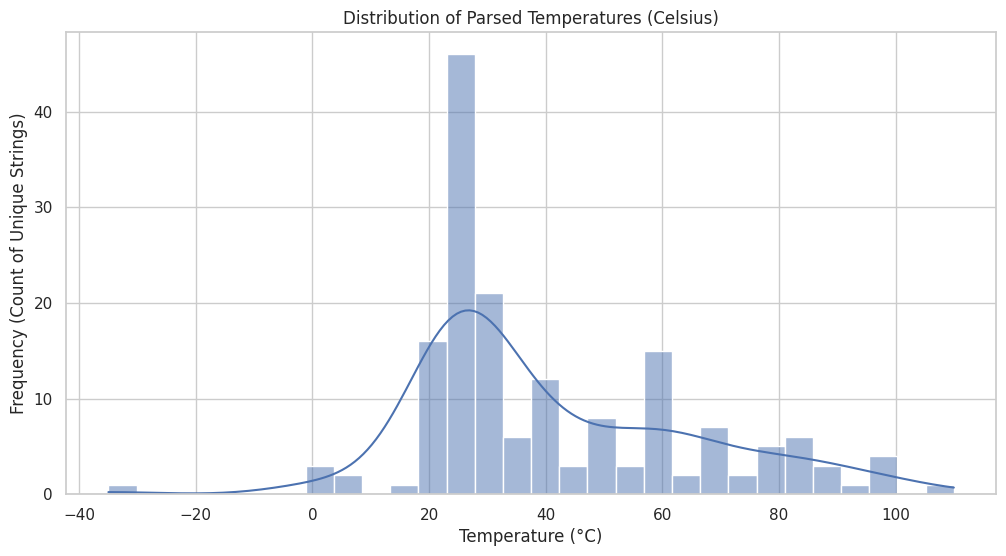

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a style for the plot
sns.set_theme(style="whitegrid")

# Create a histogram of your parsed temperature data
plt.figure(figsize=(12, 6))
sns.histplot(data=test_df, x='Parsed_Celsius', kde=True, bins=30)

plt.title('Distribution of Parsed Temperatures (Celsius)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency (Count of Unique Strings)')
plt.show()

In [46]:
def clean_and_standardize_temperature_kelvin(df: pd.DataFrame) -> pd.DataFrame:
    """
    Applies the temperature parsing logic (which returns Celsius)
    and converts the result to a standardized 'temperature_kelvin' column.
    """
    print("Standardizing temperature column to Kelvin...")

    # 1. Apply your original Celsius parsing function
    celsius_temps = df['temperature'].apply(parse_temperature_by_unit)

    # 2. Convert the Celsius result to Kelvin and create the new column
    #    (Note: np.nan + 273.15 correctly results in np.nan)
    df['temperature_kelvin'] = celsius_temps + 273.15

    # 3. Report on the final 'temperature_kelvin' column
    parsed_count = df['temperature_kelvin'].notna().sum()
    print(f"  -> Successfully parsed and converted {parsed_count} / {len(df)} temperature entries.")
    return df

In [47]:

# This runs the cleaning process for temperature and updates the DataFrame
cleaned_temperature_df = clean_and_standardize_temperature_kelvin(df)


Standardizing temperature column to Kelvin...
  -> Successfully parsed and converted 3459 / 3790 temperature entries.


# Clean duplicate papers and multiple mention of same conductivity data in multiple section of a paper

In [70]:
import pandas as pd
import numpy as np

def preprocess_conductivity_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocesses the conductivity DataFrame in two stages:

    1. Removes 100% identical row duplicates.
    2. Aggregates rows that represent the same unique measurement
       (paper + material + temp + conductivity) by combining their
       textual descriptions (e.g., source_location, material_description).

    Args:
        df: The raw DataFrame.

    Returns:
        A new DataFrame (df_aggregated) that has been fully cleaned
        and aggregated.
    """

    # --- Step 1: Remove 100% Identical Rows ---
    print(f"Original shape (before any cleaning): {df.shape}")
    df_cleaned = df.drop_duplicates()

    # Calculate rows removed in this step
    rows_removed = len(df) - len(df_cleaned)
    print(f"  -> Removed {rows_removed} exact duplicate rows.")
    print(f"Shape after Step 1: {df_cleaned.shape}")


    # --- Step 2: Aggregate Unique Measurements ---

    # 1. Define "key" columns that identify a unique measurement
    key_columns = [
        'paper_title',
        'full_name',
        'temperature_kelvin',
        'ionic_conductivity_S_per_cm'
    ]

    # 2. Define the aggregation strategy for all other columns
    aggregation_strategy = {
        # Columns to keep the 'first' value (they should be identical)
        'paper_authors': 'first',
        'acronym': 'first',
        'material_class': 'first',

        # Columns to combine into a single string
        # This lambda function gets unique, non-null string values
        # and joins them with a ' | ' separator.
        'material_description': lambda x: ' | '.join(set(x.dropna().astype(str))),
        'processing_method': lambda x: ' | '.join(set(x.dropna().astype(str))),
        'source_location': lambda x: ' | '.join(set(x.dropna().astype(str))),
        'temperature': lambda x: ' | '.join(set(x.dropna().astype(str))),
    }

    print("\nStarting Step 2: Aggregating contextual duplicates...")

    # 3. Perform the groupby aggregation
    df_aggregated = df_cleaned.groupby(key_columns, as_index=False).agg(aggregation_strategy)

    # Calculate rows combined in this step
    rows_combined = len(df_cleaned) - len(df_aggregated)
    print(f"  -> Combined {rows_combined} contextual rows.")
    print(f"Final aggregated shape (after Step 2): {df_aggregated.shape}")

    return df_aggregated

In [71]:
# Assuming 'df' is your original, raw DataFrame
de_duplicated_df = preprocess_conductivity_data(cleaned_temperature_df)

# Now, 'cleaned_df' is the DataFrame you should use for all future work
print("\n--- Preprocessing Complete ---")
print(de_duplicated_df.head())

Original shape (before any cleaning): (3790, 11)
  -> Removed 0 exact duplicate rows.
Shape after Step 1: (3790, 11)

Starting Step 2: Aggregating contextual duplicates...
  -> Combined 621 contextual rows.
Final aggregated shape (after Step 2): (3169, 11)

--- Preprocessing Complete ---
                                         paper_title  \
0  "Polymer in ceramic" type LLZTO/PEO/PVDF compo...   
1  "Polymer in ceramic" type LLZTO/PEO/PVDF compo...   
2  "Polymer in ceramic" type LLZTO/PEO/PVDF compo...   
3  "Polymer in ceramic" type LLZTO/PEO/PVDF compo...   
4  "Polymer in ceramic" type LLZTO/PEO/PVDF compo...   

                                           full_name  temperature_kelvin  \
0  Li6.4La2.95Nb0.05Zr2O12/Polyvinylidene fluorid...              298.15   
1  Li6.4La3Zr1.4Ta0.6O12/polyethylene oxide/polyv...              293.15   
2  Li6.4La3Zr1.4Ta0.6O12/polyethylene oxide/polyv...              293.15   
3  Li6.4La3Zr1.4Ta0.6O12/polyethylene oxide/polyv...              298.

# Prepare column for LLM Embeddings

In [87]:
import pandas as pd

def create_llm_description(row):
    """
    Combines key columns into a single, semi-colon-separated
    string in a 'key: value' format.
    """
    parts = []

    # 1. Add full name (if it exists)
    if pd.notna(row['full_name']):
        parts.append(f"full_name: {row['full_name']}")

    # 2. Add acronym (if it exists)
    if pd.notna(row['acronym']):
        parts.append(f"acronym: {row['acronym']}")

    # 3. Add material class (if it exists)
    if pd.notna(row['material_class']):
        parts.append(f"material_class: {row['material_class']}")

    # 4. Add material description (if it exists)
    if pd.notna(row['material_description']):
        # .strip() cleans up any leading/trailing whitespace
        parts.append(f"description: {row['material_description'].strip()}")

    # 5. Add processing method (if it exists)
    if pd.notna(row['processing_method']):
        parts.append(f"processing: {row['processing_method'].strip()}")

    # 6. Add temperature (it should always exist after your cleaning)
    if pd.notna(row['temperature_kelvin']):
        # Format the number and add the unit 'K' for context
        parts.append(f"temperature: {row['temperature_kelvin']:.2f} K")

    # Join all the parts with a semi-colon and a space
    return '; '.join(parts)


In [88]:

print("Creating 'llm_description' column...")

# axis=1 tells pandas to apply the function to each ROW
de_duplicated_df['llm_description'] = de_duplicated_df.apply(create_llm_description, axis=1)

print("--- Done. ---")

# --- Check the Result ---
# Use .iloc[0] to see the full text of the first row
print("\nExample of the first row's new description:")
print(de_duplicated_df['llm_description'].iloc[0])

Creating 'llm_description' column...
--- Done. ---

Example of the first row's new description:
full_name: Li6.4La2.95Nb0.05Zr2O12/Polyvinylidene fluoride-co-hexafluoropropylene; acronym: LLZN/PVDF-HFP; material_class: Other; description: N/A (Cited Work); processing: N/A (Cited Work); temperature: 298.15 K


# Embeddings

In [98]:
import os
import google.generativeai as genai
from google.colab import userdata
api_key = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=api_key)

In [99]:

# NEW: Choose your embedding provider here ("openai" or "gemini")
EMBEDDING_PROVIDER = "gemini"
EMBEDDING_MODEL= "gemini-embedding-001"

MODEL_CONFIG = {
    "gemini-embedding-001": 768  # We will request this size for consistency
}

In [107]:
import pandas as pd
import numpy as np
from google import genai
from google.genai import types
import time  # Import the time module for sleeping

import pandas as pd
import numpy as np
from google import genai
from google.genai import types
import time
from tqdm import tqdm  # 1. Import tqdm

def get_gemini_embeddings(
    texts: list[str],
    model_name: str = "gemini-embedding-001",
    task_type: str = "SEMANTIC_SIMILARITY",
    api_key=api_key,
    output_dimensionality: int = 768
) -> list[np.ndarray]:
    """
    Generates raw (unnormalized) embeddings for a list of texts using the Gemini API,
    handling batch size limits and showing a progress bar with tqdm.
    """

    client = genai.Client(api_key=api_key)
    BATCH_SIZE = 100
    all_raw_embeddings = []

    print(f"Generating {len(texts)} embeddings in batches of {BATCH_SIZE}...")

    # 2. Wrap the range() in tqdm()
    # This will automatically create and update a progress bar
    for i in tqdm(range(0, len(texts), BATCH_SIZE)):

        batch_texts = texts[i : i + BATCH_SIZE]

        # (The print statement is no longer needed, tqdm handles it)
        # print(f"  ... processing batch {i // BATCH_SIZE + 1} ...")

        try:
            result = client.models.embed_content(
                model=model_name,
                contents=batch_texts,
                config=types.EmbedContentConfig(
                    task_type=task_type,
                    output_dimensionality=output_dimensionality
                )
            )

            batch_raw_embeddings = [np.array(e.values) for e in result.embeddings]
            all_raw_embeddings.extend(batch_raw_embeddings)

        except Exception as e:
            print(f"An error occurred on a batch: {e}")
            continue

        time.sleep(1)

    print(f"Successfully generated {len(all_raw_embeddings)} raw embeddings.")
    return all_raw_embeddings

def normalize_embeddings(embeddings_list: list[np.ndarray]) -> list[np.ndarray]:
    """
    Normalizes a list of embedding vectors using L2 normalization.
    """
    print(f"Normalizing {len(embeddings_list)} embeddings...")
    normalized_embeddings = []

    for embedding_np in embeddings_list:
        # Calculate the L2 norm (magnitude) of the vector [cite: 138]
        norm = np.linalg.norm(embedding_np)

        if norm > 0:
            # Divide by the norm to get a unit vector [cite: 138]
            normed_vector = embedding_np / norm
            normalized_embeddings.append(normed_vector)
        else:
            # Handle zero-vectors (though unlikely)
            normalized_embeddings.append(embedding_np)

    print("Normalization complete.")
    return normalized_embeddings

In [108]:
# Assuming 'de_duplicated_df' is your DataFrame
texts_to_embed = de_duplicated_df['llm_description'].tolist()

# Step 1: Get the raw embeddings
raw_embeddings = get_gemini_embeddings(texts_to_embed)

# Step 2: Normalize the raw embeddings
if raw_embeddings:
    normalized_embeddings = normalize_embeddings(raw_embeddings)

    # Step 3: Store them in your DataFrame
    de_duplicated_df['embedding'] = normalized_embeddings
    print("\n--- Success! 'embedding' column added. ---")

    # Verify the result
    print(f"Dimension: {len(de_duplicated_df['embedding'].iloc[0])}")
    print(f"Norm: {np.linalg.norm(de_duplicated_df['embedding'].iloc[0]):.6f}")

Generating 3169 embeddings in batches of 100...


100%|██████████| 32/32 [00:56<00:00,  1.77s/it]

Successfully generated 3169 raw embeddings.
Normalizing 3169 embeddings...
Normalization complete.

--- Success! 'embedding' column added. ---
Dimension: 768
Norm: 1.000000


# Simple PCA on the embeddings

In [115]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import textwrap

# --- 1. Get Embeddings and All Labels ---
embedding_matrix = np.stack(de_duplicated_df['embedding'].tolist())

# Get all the data we need for coloring and hovering
labels = de_duplicated_df['llm_description']
conductivity = de_duplicated_df['ionic_conductivity_S_per_cm']
log_conductivity = np.log10(conductivity)
paper_title = de_duplicated_df['paper_title']
paper_authors = de_duplicated_df['paper_authors']
source_location = de_duplicated_df['source_location']

# --- 2. Run PCA ---
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_matrix)
print("Shape of reduced embeddings:", reduced_embeddings.shape)

# --- 3. Create a helper function to wrap text ---
def wrap_text(text, width=100):
    """Inserts <br> tags into text to wrap it for plotly hover."""
    if not isinstance(text, str):
        return ""
    lines = textwrap.wrap(text, width=width)
    return '<br>'.join(lines)

# --- 4. Create a temporary DataFrame for plotting ---
df_plot = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])

# Add all our data to the plot DataFrame
df_plot['description_text'] = labels.apply(lambda x: wrap_text(x, 80)) # Wrap desc
df_plot['conductivity_raw'] = conductivity
df_plot['conductivity_log10'] = log_conductivity
# --- Add metadata and wrap it ---
df_plot['paper_title'] = paper_title.apply(lambda x: wrap_text(x, 80))
df_plot['paper_authors'] = paper_authors.apply(lambda x: wrap_text(x, 80))
df_plot['source_location'] = source_location # Usually short, no wrap needed

# --- 5. Create the Interactive Plot (with new features) ---
fig = px.scatter(
    df_plot,
    x='PC1',
    y='PC2',
    title="PCA of Embeddings (Colored by Log(Conductivity), with Metadata)",

    # --- Color ---
    color='conductivity_log10',
    color_continuous_scale=px.colors.sequential.Viridis,
    labels={'conductivity_log10': 'Log10(Conductivity)'},

    # --- Custom hover data ---
    hover_data={
        'PC1': False,
        'PC2': False,
        'conductivity_raw': ':.2e',
        'conductivity_log10': ':.2f',
        'description_text': True,
        'paper_title': True,
        'paper_authors': True,
        'source_location': True,
    }
)

# --- 6. Finalize the hover template ---
# This new template includes all the metadata
fig.update_traces(
    hovertemplate=(
        # --- Conductivity Info ---
        "<b>Log(Conductivity):</b> %{customdata[1]:.2f}<br>"
        "<b>Conductivity:</b> %{customdata[0]:.2e} S/cm<br>"

        # --- Description ---
        "<br><b>Description:</b><br>%{customdata[2]}<br>"

        # --- Metadata ---
        "<br><b>Paper Title:</b><br>%{customdata[3]}<br>"
        "<b>Authors:</b><br>%{customdata[4]}<br>"
        "<b>Source:</b> %{customdata[5]}"

        # --- Footer ---
        "<extra></extra>" # Hides the trace name
    )
)

fig.show()

Shape of reduced embeddings: (3169, 2)


In [192]:
import pandas as pd
import numpy as np

# --- 1. Use the existing df_plot DataFrame ---
# It already contains PC1, PC2, conductivity_log10, description_text.

print("Using existing DataFrame 'df_plot' containing PCA scores.")

# --- 2. Find and Display Extremes ---
N_EXTREMES = 10 # How many samples to show from each end

print(f"\n--- Analyzing Extremes (Top & Bottom {N_EXTREMES} Samples) ---")

# --- PC1 Extremes ---
print("\n### Principal Component 1 Extremes ###")
# Use df_plot directly
pc1_lowest = df_plot.sort_values(by='PC1', ascending=True).head(N_EXTREMES)
pc1_highest = df_plot.sort_values(by='PC1', ascending=False).head(N_EXTREMES)

print(f"\n--- Lowest PC1 Scores (Bottom {N_EXTREMES}) ---")
# Display relevant columns - removed material_class, using description_text
print(pc1_lowest[['PC1', 'conductivity_log10', 'description_text']].to_markdown(index=False, floatfmt=".2f"))

print(f"\n--- Highest PC1 Scores (Top {N_EXTREMES}) ---")
print(pc1_highest[['PC1', 'conductivity_log10', 'description_text']].to_markdown(index=False, floatfmt=".2f"))


# --- PC2 Extremes ---
print("\n\n### Principal Component 2 Extremes ###")
pc2_lowest = df_plot.sort_values(by='PC2', ascending=True).head(N_EXTREMES)
pc2_highest = df_plot.sort_values(by='PC2', ascending=False).head(N_EXTREMES)

print(f"\n--- Lowest PC2 Scores (Bottom {N_EXTREMES}) ---")
print(pc2_lowest[['PC2', 'conductivity_log10', 'description_text']].to_markdown(index=False, floatfmt=".2f"))

print(f"\n--- Highest PC2 Scores (Top {N_EXTREMES}) ---")
print(pc2_highest[['PC2', 'conductivity_log10', 'description_text']].to_markdown(index=False, floatfmt=".2f"))

Using existing DataFrame 'df_plot' containing PCA scores.

--- Analyzing Extremes (Top & Bottom 10 Samples) ---

### Principal Component 1 Extremes ###

--- Lowest PC1 Scores (Bottom 10) ---
|   PC1 |   conductivity_log10 | description_text                                                                                                                                                                  |
|------:|---------------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| -0.27 |                 0.00 | full_name: Lithium Germanium Phosphorus Sulfide; acronym: LGPS; material_class:<br>Ceramic; description: N/A (Cited Work); processing: N/A (Cited Work);<br>temperature: 298.15 K |
| -0.27 |                 0.08 | full_name: Lithium Germanium Phosphorus Sulfide; acronym: LGPS; material_class:<br>Ceramic; description: N/A (Cited Work); processing: N/

# Train ML model on this embedding

In [116]:
!pip install xgboost

In [132]:
import numpy as np
import pandas as pd
import time
import xgboost as xgb
from tqdm import tqdm

# --- Core Sklearn Imports ---
from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

# --- Model Imports ---
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor


In [133]:
# Create the log-transformed target
de_duplicated_df['log_conductivity'] = np.log10(de_duplicated_df['ionic_conductivity_S_per_cm'])

# Drop rows with any NaN values in our key columns
df_model = de_duplicated_df.dropna(subset=['embedding', 'log_conductivity'])

# --- 1. Define X and y ---
# Stack the embeddings into a single numpy array
X = np.stack(df_model['embedding'].tolist())
# Our target variable
y = df_model['log_conductivity']

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (3169, 768)
Shape of y: (3169,)


In [134]:

pipelines_to_test = {
    "Random Forest (Raw)": Pipeline([
        ('model', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    # --- ADDED device='cuda' for GPU acceleration ---
    "XGBoost (Raw)": Pipeline([
        ('model', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42,
                                  n_jobs=-1, device='cuda'))
    ]),
    "Linear Regression (Scaled)": Pipeline([
        ('scaler', StandardScaler()), ('model', LinearRegression())
    ]),
    "Lasso (Scaled)": Pipeline([
        ('scaler', StandardScaler()), ('model', Lasso(alpha=0.1, random_state=42))
    ]),
    "Ridge (Scaled)": Pipeline([
        ('scaler', StandardScaler()), ('model', Ridge(alpha=1.0, random_state=42))
    ]),
    "Bayesian Ridge (Scaled)": Pipeline([
        ('scaler', StandardScaler()), ('model', BayesianRidge())
    ]),
    "SVR (Scaled)": Pipeline([
        ('scaler', StandardScaler()), ('model', SVR(kernel='rbf'))
    ]),
    "PLS Regression (Scaled)": Pipeline([
        ('scaler', StandardScaler()), ('model', PLSRegression(n_components=100))
    ]),
    "MLP (Scaled)": Pipeline([
        ('scaler', StandardScaler()),
        ('model', MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                               max_iter=500, alpha=0.001, early_stopping=True, random_state=42))
    ]),
    "Linear Regression (PCA)": Pipeline([
        ('scaler', StandardScaler()), ('pca', PCA(n_components=100)), ('model', LinearRegression())
    ]),
    "Ridge (PCA)": Pipeline([
        ('scaler', StandardScaler()), ('pca', PCA(n_components=100)), ('model', Ridge(alpha=1.0, random_state=42))
    ]),
    "Random Forest (PCA)": Pipeline([
        ('scaler', StandardScaler()), ('pca', PCA(n_components=100)),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    # --- ADDED device='cuda' for GPU acceleration ---
    "XGBoost (PCA)": Pipeline([
        ('scaler', StandardScaler()), ('pca', PCA(n_components=100)),
        ('model', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42,
                                  n_jobs=-1, device='cuda'))
    ]),
    "SVR (PCA)": Pipeline([
        ('scaler', StandardScaler()), ('pca', PCA(n_components=100)), ('model', SVR(kernel='rbf'))
    ]),
    "Bayesian Ridge (PCA)": Pipeline([
        ('scaler', StandardScaler()), ('pca', PCA(n_components=100)), ('model', BayesianRidge())
    ]),
}


In [135]:

# -------------------------------------------------------------------
# 3. MANUAL K-FOLD CROSS-VALIDATION WORKFLOW
# -------------------------------------------------------------------
print(f"--- 3. Starting 5-Fold Cross-Validation for {len(pipelines_to_test)} Pipelines ---")

# Define the 5-fold cross-validation strategy
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# This list will store one dictionary for every model for every fold
all_fold_results = []

# --- Outer loop: Iterate through each model pipeline ---
for name, pipeline in pipelines_to_test.items():

    # --- Inner loop: Iterate through each of the 5 folds ---
    # Use tqdm for a progress bar for the folds
    fold_iterator = tqdm(
        enumerate(kfold.split(X, y)),
        total=5,
        desc=f"Running Model: {name}"
    )

    for fold, (train_index, test_index) in fold_iterator:

        # 1. Get the data for this fold
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        # 2. Fit the pipeline
        start_time = time.time()
        pipeline.fit(X_train_fold, y_train_fold)
        fit_time = time.time() - start_time

        # 3. Get predictions for BOTH train and test sets
        y_pred_train = pipeline.predict(X_train_fold)
        y_pred_test = pipeline.predict(X_test_fold)

        # 4. Calculate all metrics for TRAIN data
        train_r2 = r2_score(y_train_fold, y_pred_train)
        train_rmse = np.sqrt(mean_squared_error(y_train_fold, y_pred_train))
        train_mae = mean_absolute_error(y_train_fold, y_pred_train)

        # 5. Calculate all metrics for TEST data
        test_r2 = r2_score(y_test_fold, y_pred_test)
        test_rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred_test))
        test_mae = mean_absolute_error(y_test_fold, y_pred_test)

        # 6. Store all results in a dictionary
        fold_result = {
            "Model": name,
            "Fold": fold + 1,

            "Train R2": train_r2,
            "Test R2": test_r2,

            "Train RMSE": train_rmse,
            "Test RMSE": test_rmse,

            "Train MAE": train_mae,
            "Test MAE": test_mae,

            "Fit Time (s)": fit_time
        }

        all_fold_results.append(fold_result)

print("\n--- 4. Cross-Validation Complete ---")


--- 3. Starting 5-Fold Cross-Validation for 15 Pipelines ---


Running Model: XGBoost (Raw):   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[05:47:48] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[05:47:48] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.

Running Model: XGBoost (Raw):  20%|██        | 1/5 [00:28<01:55, 28.95s/it]/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[05:48:16] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[05:48:16] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.

Running Model: XGBoost (Raw):  40%|████      | 2/5 [00:56<01:25, 2


--- 4. Cross-Validation Complete ---


In [136]:
# --- Report 1: The Full, "Long" DataFrame (one row per fold) ---

results_long_df = pd.DataFrame(all_fold_results)

# --- Report 2: The Aggregated "Mean" DataFrame ---
# This is a summary report, grouped by model
results_mean_df = results_long_df.groupby('Model').mean().drop(columns='Fold')
# Sort by the best (lowest) Test RMSE
results_mean_df = results_mean_df.sort_values(by="Test RMSE", ascending=True)


print("\n\n---  FINAL AGGREGATED BENCHMARK (Mean Scores) ---")
print(results_mean_df.to_markdown(floatfmt=".4f"))

print("\n\n---  DETAILED FOLD-BY-FOLD RESULTS ---")
print(results_long_df.to_markdown(index=False, floatfmt=".4f"))




---  FINAL AGGREGATED BENCHMARK (Mean Scores) ---
| Model                      |   Train R2 |   Test R2 |   Train RMSE |   Test RMSE |   Train MAE |   Test MAE |   Fit Time (s) |
|:---------------------------|-----------:|----------:|-------------:|------------:|------------:|-----------:|---------------:|
| MLP (Scaled)               |     0.8700 |    0.4783 |       0.8737 |      1.7521 |      0.5592 |     1.2157 |         2.4347 |
| XGBoost (Raw)              |     0.9522 |    0.4405 |       0.5306 |      1.8140 |      0.3513 |     1.3529 |        29.3838 |
| XGBoost (PCA)              |     0.8947 |    0.4334 |       0.7856 |      1.8252 |      0.5251 |     1.3678 |         4.8297 |
| SVR (Scaled)               |     0.6097 |    0.4290 |       1.5168 |      1.8331 |      0.9223 |     1.2760 |         3.4580 |
| Random Forest (Raw)        |     0.8964 |    0.4121 |       0.7813 |      1.8600 |      0.5887 |     1.4690 |       256.2134 |
| Random Forest (PCA)        |     0.8757 |  


Benchmark plot saved as 'model_rmse_train_test_benchmark.png'


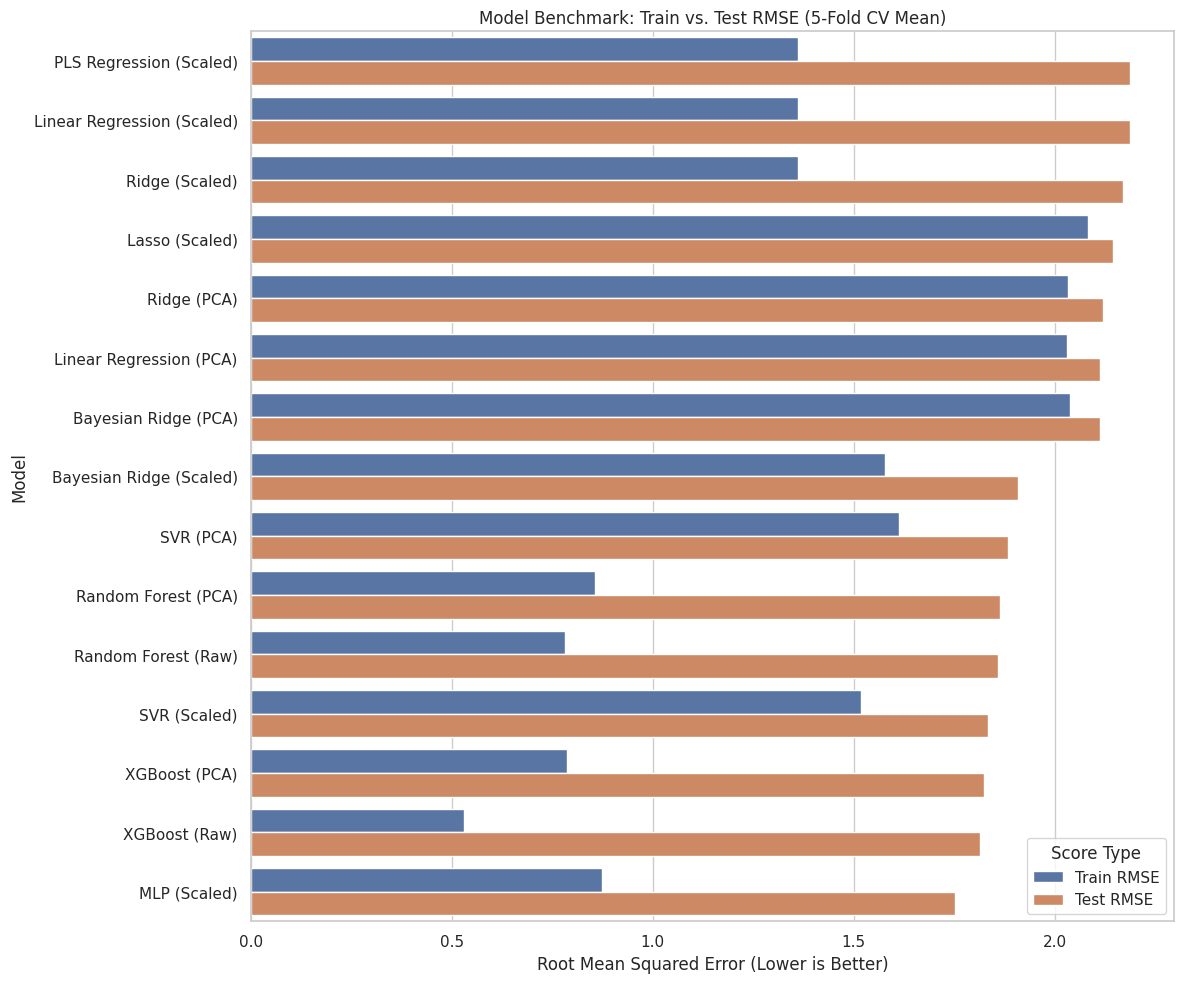

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_train_test_rmse(benchmark_df: pd.DataFrame):
    """
    Generates a grouped bar chart comparing Train RMSE and Test RMSE
    for all models, sorted by Test RMSE.

    Args:
        benchmark_df: The aggregated (mean) results DataFrame.
    """

    # 1. Reset the index so 'Model' becomes a column (needed for melting)
    df_to_plot = benchmark_df.reset_index()

    # 2. Sort the DataFrame by Test RMSE (lowest error is best)
    df_sorted = df_to_plot.sort_values(by="Test RMSE", ascending=False)

    # 3. "Melt" the DataFrame into a "long" format
    # This is needed for Seaborn's grouped bar chart.
    # We use the 'Train RMSE' and 'Test RMSE' columns.
    df_melted = df_sorted.melt(
        id_vars='Model',
        value_vars=['Train RMSE', 'Test RMSE'], # Use the correct column names
        var_name='Score Type',
        value_name='RMSE'
    )

    # 4. Create the plot
    plt.figure(figsize=(12, 10))
    sns.set_theme(style="whitegrid")

    chart = sns.barplot(
        data=df_melted,
        y='Model',
        x='RMSE',
        hue='Score Type', # This creates the side-by-side bars
        orient='h'
    )

    plt.xlabel("Root Mean Squared Error (Lower is Better)")
    plt.ylabel("Model")
    plt.title("Model Benchmark: Train vs. Test RMSE (5-Fold CV Mean)")
    plt.legend(title='Score Type', loc='lower right')
    plt.tight_layout()
    plt.savefig("model_rmse_train_test_benchmark.png")
    print("\nBenchmark plot saved as 'model_rmse_train_test_benchmark.png'")

# --- How to run it ---
# Call the function on your results DataFrame
plot_train_test_rmse(results_mean_df)

# K-fold performance of the tuned MLP Regressor

In [171]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# -------------------------------------------------------------------
# 1. PREPARE DATA (Same as the original MLP tuning)
# -------------------------------------------------------------------
print("--- 1. Preparing Data (Embeddings Only) ---")
df_model = de_duplicated_df.dropna(subset=['embedding', 'log_conductivity'])
y = df_model['log_conductivity'].values
X = np.stack(df_model['embedding'].tolist())

# --- Perform Scaling ---
# We scale the *entire* dataset here because cross_validate
# internally handles splitting *after* the pipeline steps.
# The pipeline itself contains the scaler, ensuring no leakage.
# scaler = StandardScaler() # No need to scale outside if it's in the pipeline
# X_scaled = scaler.fit_transform(X) # Don't scale here

print(f"Data prepared: X shape {X.shape}, y shape {y.shape}")

# -------------------------------------------------------------------
# 2. GET THE BEST PIPELINE FROM GridSearchCV
# -------------------------------------------------------------------
# IMPORTANT: Make sure the 'grid_search' object from your previous
# MLP tuning run is still available in your notebook's memory.
# If not, you might need to re-run that GridSearchCV cell first.

try:
    best_sklearn_mlp_pipeline = grid_search.best_estimator_
    print("\n--- 2. Retrieved Best Sklearn MLP Pipeline from GridSearchCV ---")
    print(best_sklearn_mlp_pipeline) # Optional: Print to verify
except NameError:
    print("\nError: 'grid_search' object not found.")
    print("Please re-run the GridSearchCV cell for the sklearn MLP first.")
    # Exit or handle error appropriately
    raise

# -------------------------------------------------------------------
# 3. RUN K-FOLD CROSS-VALIDATION
# -------------------------------------------------------------------
print("\n--- 3. Starting K-Fold CV for Tuned Sklearn MLP ---")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['r2', 'neg_root_mean_squared_error']

# Use the full X (unscaled) because the pipeline includes the scaler
cv_results = cross_validate(
    best_sklearn_mlp_pipeline,
    X, # Feed the raw embeddings
    y,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1, # Use all CPU cores
    return_train_score=False # We only need test scores for this comparison
)

print("--- Cross-Validation Complete ---")

# -------------------------------------------------------------------
# 4. REPORT FINAL K-FOLD RESULTS
# -------------------------------------------------------------------
mean_r2 = cv_results['test_r2'].mean()
std_r2 = cv_results['test_r2'].std()
mean_rmse = -cv_results['test_neg_root_mean_squared_error'].mean()
std_rmse = cv_results['test_neg_root_mean_squared_error'].std()

print("\n\n--- FINAL K-FOLD RESULTS for Tuned Sklearn MLP ---")
print(f"Mean R²: {mean_r2:.4f} (+/- {std_r2:.4f})")
print(f"Mean RMSE: {mean_rmse:.4f} (+/- {std_rmse:.4f})")

--- 1. Preparing Data (Embeddings Only) ---
Data prepared: X shape (3169, 768), y shape (3169,)

--- 2. Retrieved Best Sklearn MLP Pipeline from GridSearchCV ---
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 MLPRegressor(alpha=0.001, early_stopping=True,
                              hidden_layer_sizes=(150, 75), max_iter=500,
                              random_state=42))])

--- 3. Starting K-Fold CV for Tuned Sklearn MLP ---
--- Cross-Validation Complete ---


--- FINAL K-FOLD RESULTS for Tuned Sklearn MLP ---
Mean R²: 0.4812 (+/- 0.0203)
Mean RMSE: 1.7474 (+/- 0.0855)

--- FOR COMPARISON ---
Hybrid Keras (K-Fold Mean) R²: 0.4107 (+/- 0.0414)
Hybrid Keras (K-Fold Mean) RMSE: 1.8605 (+/- 0.0862)


# Clustering

In [172]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import textwrap

# --- Assuming these functions are defined from previous steps ---
# from your_module import get_gemini_embeddings, normalize_embeddings
# from your_module import api_key # Make sure api_key is accessible

# --- Sklearn Imports ---
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler # For embeddings before t-SNE


In [175]:

# -------------------------------------------------------------------
# 1. GENERATE CLUSTERING-SPECIFIC EMBEDDINGS
# -------------------------------------------------------------------
print("--- 1. Generating Clustering Embeddings ---")

# (Assuming 'de_duplicated_df' is your final clean DataFrame)
# Make sure to drop NaNs in the description column first
df_cluster = de_duplicated_df.dropna(subset=['llm_description'])
texts_to_embed = df_cluster['llm_description'].tolist()

# Get raw embeddings using the CLUSTERING task type
# Note: Normalization is *not* typically recommended before clustering algorithms like K-Means
# that rely on Euclidean distance, but it IS needed for t-SNE visualization.
# We'll get raw embeddings first, then scale *a copy* for t-SNE.
raw_cluster_embeddings = get_gemini_embeddings(
    texts_to_embed,
    task_type="CLUSTERING", # Use the clustering task type [cite: 1223, 1230]
    api_key=api_key # Pass your API key
)

if not raw_cluster_embeddings:
    print("Error generating embeddings. Exiting.")
    # Exit or handle error
    exit()

# Store raw embeddings (useful for K-Means)
df_cluster['embedding_cluster_raw'] = raw_cluster_embeddings
embedding_matrix_raw = np.stack(raw_cluster_embeddings)


--- 1. Generating Clustering Embeddings ---
Generating 3169 embeddings in batches of 100...


100%|██████████| 32/32 [00:54<00:00,  1.71s/it]

Successfully generated 3169 raw embeddings.


In [176]:
# -------------------------------------------------------------------
# 2. DIMENSIONALITY REDUCTION FOR VISUALIZATION (t-SNE)
# -------------------------------------------------------------------
print("\n--- 2. Performing t-SNE for Visualization ---")

# Scale the embeddings *before* t-SNE (important for t-SNE)
scaler_tsne = StandardScaler()
embedding_matrix_scaled = scaler_tsne.fit_transform(embedding_matrix_raw)

# Initialize t-SNE
tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30, # A common starting value
    n_iter=1000,   # Number of optimization iterations
    init='pca',    # Use PCA initialization for stability
    learning_rate='auto'
)

# Fit and transform
tsne_results = tsne.fit_transform(embedding_matrix_scaled)
print(f"t-SNE complete. Shape of reduced embeddings: {tsne_results.shape}")

# Add t-SNE results to DataFrame
df_cluster['TSNE1'] = tsne_results[:, 0]
df_cluster['TSNE2'] = tsne_results[:, 1]


--- 2. Performing t-SNE for Visualization ---
t-SNE complete. Shape of reduced embeddings: (3169, 2)



--- 3. Performing K-Means Clustering ---
--- Finding Optimal Number of Clusters (k) ---
Calculating inertia for elbow method...


100%|██████████| 14/14 [00:03<00:00,  3.64it/s]



Calculating silhouette scores...


100%|██████████| 14/14 [00:12<00:00,  1.17it/s]



Plot for optimal k saved as 'kmeans_optimal_k.png'

'kneed' library not installed. Cannot automatically detect elbow.
Please inspect 'kmeans_optimal_k.png' to choose k manually.
k with maximum silhouette score = 2

Using 2 clusters for final K-Means.


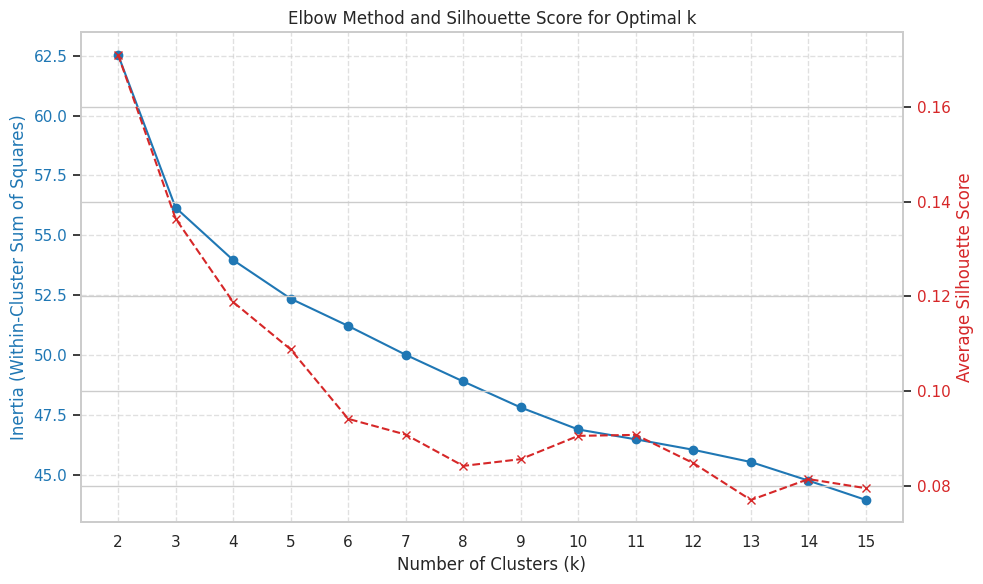

In [182]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming 'embedding_matrix_raw' is your numpy array of raw embeddings
# embedding_matrix_raw = np.stack(raw_cluster_embeddings)

# -------------------------------------------------------------------
# 3. K-MEANS CLUSTERING (with Optimal k Selection)
# -------------------------------------------------------------------
print("\n--- 3. Performing K-Means Clustering ---")
print("--- Finding Optimal Number of Clusters (k) ---")

# --- Define Range of k to Test ---
k_range = range(2, 16) # Test k from 2 up to 15 clusters

# --- Calculate Inertia (Elbow Method) ---
inertia_values = []
print("Calculating inertia for elbow method...")
for k in tqdm(k_range):
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_temp.fit(embedding_matrix_raw)
    inertia_values.append(kmeans_temp.inertia_)

# --- Calculate Silhouette Scores ---
silhouette_scores = []
print("\nCalculating silhouette scores...")
# Silhouette score is computationally intensive, calculate only if needed
# or use a sample if the dataset is very large
# sample_indices = np.random.choice(embedding_matrix_raw.shape[0], size=min(1000, embedding_matrix_raw.shape[0]), replace=False)
# embedding_sample = embedding_matrix_raw[sample_indices]
embedding_sample = embedding_matrix_raw # Using full data for now

for k in tqdm(k_range):
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels_temp = kmeans_temp.fit_predict(embedding_sample)
    # Silhouette score requires at least 2 labels
    if len(set(cluster_labels_temp)) > 1:
        score = silhouette_score(embedding_sample, cluster_labels_temp)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1) # Indicate failure for this k

# --- Plotting the Results ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Inertia (Elbow Method)
color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Within-Cluster Sum of Squares)', color=color)
ax1.plot(k_range, inertia_values, marker='o', color=color, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.6)

# Create a second y-axis for Silhouette Score
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Silhouette Score', color=color)
ax2.plot(k_range, silhouette_scores, marker='x', linestyle='--', color=color, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elbow Method and Silhouette Score for Optimal k')
fig.tight_layout()
plt.xticks(list(k_range)) # Ensure all k values are shown as ticks
plt.savefig("kmeans_optimal_k.png")
print("\nPlot for optimal k saved as 'kmeans_optimal_k.png'")
# plt.show() # Uncomment to display plot if running locally

# --- Determine Optimal k ---
# Option 1: Manual Inspection - Look at the plot saved as 'kmeans_optimal_k.png'
#           Find the 'elbow' in the blue inertia line (where it starts bending less sharply).
#           Find the peak in the red silhouette score line. Choose a 'k' that balances both.
# Option 2: Automatic Elbow Detection (requires 'kneed' library: pip install kneed)
try:
    from kneed import KneeLocator
    kl = KneeLocator(list(k_range), inertia_values, curve='convex', direction='decreasing')
    optimal_k_elbow = kl.elbow
    print(f"\nAutomatically detected elbow at k = {optimal_k_elbow}")
except ImportError:
    optimal_k_elbow = None
    print("\n'kneed' library not installed. Cannot automatically detect elbow.")
    print("Please inspect 'kmeans_optimal_k.png' to choose k manually.")

# Option 3: Choose k based on max Silhouette Score
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"k with maximum silhouette score = {optimal_k_silhouette}")


# --- *** CHOOSE YOUR OPTIMAL K HERE *** ---
# Replace with the value you determined by inspecting the plot or using automatic detection
# For example: N_CLUSTERS = optimal_k_elbow if optimal_k_elbow else optimal_k_silhouette
N_CLUSTERS = optimal_k_silhouette # Example: Prioritizing silhouette score

print(f"\nUsing {N_CLUSTERS} clusters for final K-Means.")


In [183]:

# --- Perform Final Clustering with Optimal k ---
kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=42,
    n_init='auto'
)

# Fit K-Means on the RAW (unscaled) high-dimensional embeddings
cluster_labels = kmeans.fit_predict(embedding_matrix_raw)
# df_cluster['Cluster'] = cluster_labels # Assuming df_cluster exists from previous steps
print(f"K-Means complete. Assigned {N_CLUSTERS} clusters.")



K-Means complete. Assigned 2 clusters.


In [186]:
import plotly.express as px
import pandas as pd
import numpy as np
import textwrap

# (Assuming df_cluster contains:
#   'TSNE1', 'TSNE2', 'Cluster', 'llm_description',
#   'material_class', 'ionic_conductivity_S_per_cm', 'log_conductivity',
#   'paper_title', 'paper_authors', 'source_location')
# (Assuming N_CLUSTERS is defined)

# -------------------------------------------------------------------
# 4. VISUALIZE THE CLUSTERS (Markers=Cluster, Color=Conductivity, Full Hover)
# -------------------------------------------------------------------
print("\n--- 4. Creating Interactive Cluster Plot with Full Metadata ---")

# Helper function for text wrapping (same as before)
def wrap_text(text, width=100):
    if not isinstance(text, str): return ""
    lines = textwrap.wrap(text, width=width)
    return '<br>'.join(lines)

# Apply wrapping to description and metadata
df_cluster['description_wrapped'] = df_cluster['llm_description'].apply(lambda x: wrap_text(x, 80))
df_cluster['title_wrapped'] = df_cluster['paper_title'].apply(lambda x: wrap_text(x, 80))
df_cluster['authors_wrapped'] = df_cluster['paper_authors'].apply(lambda x: wrap_text(x, 80))
# source_location is usually short, no wrapping needed

# --- Create the interactive plot ---
fig = px.scatter(
    df_cluster,
    x='TSNE1',
    y='TSNE2',

    # Color by conductivity
    color='log_conductivity',
    color_continuous_scale=px.colors.sequential.Viridis,
    labels={'log_conductivity': 'Log10(Conductivity)'},

    # Use marker symbols for cluster
    symbol='Cluster',
    category_orders={"Cluster": sorted(df_cluster['Cluster'].unique())},

    title=f't-SNE Visualization (Markers=Cluster, Color=LogConductivity)',

    # --- UPDATED hover_data to include all fields ---
    hover_data={
        'TSNE1': False,
        'TSNE2': False,
        'log_conductivity': ':.2f',
        'ionic_conductivity_S_per_cm': ':.2e',
        'Cluster': True,
        'material_class': True,
        'description_wrapped': True,
        'title_wrapped': True, # Add wrapped title
        'authors_wrapped': True, # Add wrapped authors
        'source_location': True # Add source location
    }
)

# --- UPDATED hover template for detailed info ---
# Adjust customdata indices based on the new hover_data order:
# [0] log_conductivity
# [1] ionic_conductivity_S_per_cm
# [2] Cluster
# [3] material_class
# [4] description_wrapped
# [5] title_wrapped
# [6] authors_wrapped
# [7] source_location
fig.update_traces(
    hovertemplate=(
        # --- Conductivity Info ---
        "<b>Log(Conductivity):</b> %{customdata[0]:.2f}<br>"
        "<b>Conductivity:</b> %{customdata[1]:.2e} S/cm<br>"

        # --- Cluster Info ---
        "<b>Cluster:</b> %{customdata[2]}<br>"

        # --- Class ---
        "<b>Class:</b> %{customdata[3]}<br><br>"

        # --- Description ---
        "<b>Description:</b><br>%{customdata[4]}<br>"

        # --- Metadata ---
        "<br><b>Paper Title:</b><br>%{customdata[5]}<br>"
        "<b>Authors:</b><br>%{customdata[6]}<br>"
        "<b>Source:</b> %{customdata[7]}"

        # --- Footer ---
        "<extra></extra>"
    )
)

fig.show()

# You can save this plot as an HTML file
# fig.write_html("material_clusters_tsne_full_hover.html")


--- 4. Creating Interactive Cluster Plot with Full Metadata ---
